MNIST Digit Recognition with Deep Learning - Malik Endsley and Daniel Park <br/><br/>Requires: <br/><br/>Pydot<br/>Keras

Our Dataset is Digit Recognition data. The Dataset contains test and training data of tens of thousands of images of numbers. It is from the MNIST library, famously used as a “hello world” of ML.

The information included in the dataset is succinct but complete. Each row represents a 28x28 image (784 pixels). There are 42,000 training images and 28,000 testing images.

Let's take a look at the data: <br/><br/><br/>

In [71]:
#all the imports have been retroactively moved to the 
#top so they're easily seen
import pydot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model
from keras.utils.vis_utils import plot_model


trainingDigits = pd.read_csv("data/train.csv")
testingDigits = pd.read_csv("data/test.csv")
trainingDigits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
testingDigits.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our data looks *very* strange, but the Kaggle page has some insight: <br/><br/> It appears data is encoded to where each pixel gets its own column and they are arranged left to right top to bottom. For reference: <br/> 000 001 002 003 ... 027 <br/> 028 030 031 032 ... 055 <br/> and et cetera. In other words, “x = i * 28 + j” (From the page explaining the decomposition of a pixel x.) <br/><br/>
	Each pixel has a lightness/darkness value ranging from 0 to 255, inclusive, which, when put together creates a grayscale image of a digit. The dataset does not contain any actual images of the data which means to view them we will write a parser. Some sample images look like this:


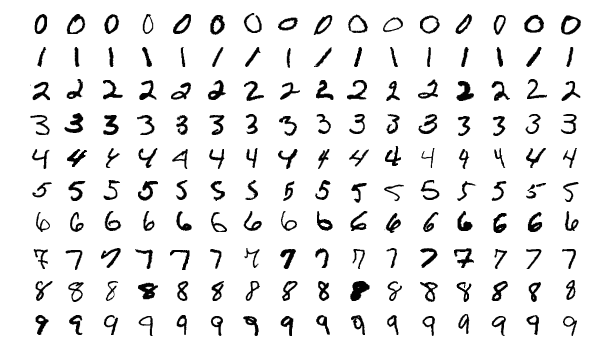

In [85]:
from IPython.display import Image
Image(filename='img/MnistExamples.png')

Let's try and gain what we can from our data before we start working. We should find the proportions of the different numbers, as well as attempt to parse some individual columns. Matplotlib and Seaborn can help with those.

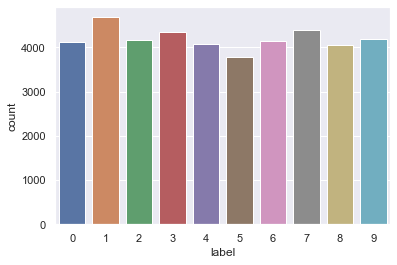

In [24]:
%matplotlib inline

sns.set(style="darkgrid")
proportionsAx = sns.countplot(x="label", data=trainingDigits)

Looks like all the numbers are represented pretty equally. There are a lot of 1s, though, and not quite as many 5s. Later, when we get predictions, we will see if more training data of a particular number improves that number's recognition. <br/> <br/> Let's get our data prepped.  <br/> <br/> 

In [25]:
X_train = trainingDigits.drop(labels = ["label"], axis=1)
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
y_train = trainingDigits["label"]
y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

We can also double-check for missing data here.

In [27]:
print("Presence of missing data on inputs: " + str(X_train.isnull().values.any()) + "\nPresence of missing data on targets: " + str(y_train.isnull().values.any()))

Presence of missing data on inputs: False
Presence of missing data on targets: False


Then we will use matplotlib and some data manipulation to convert each row into a list of 28x28 matrices of pixel data (much more easily read). 

In [28]:
X_train = X_train.values.reshape(-1,28,28,1)
X_train.shape

(42000, 28, 28, 1)

Perfect. These newly created arrays are compatible with imshow offered by matplotlib. Using some sublots and a bit of iteration, we can regenerate a portion of the data as images to see exactly what we're working with. <br/> <br/>

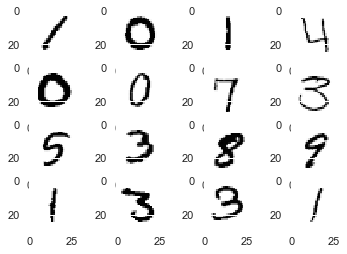

In [29]:
plt.rcParams["axes.grid"] #remove gridlines
fig, ax = plt.subplots(nrows=4, ncols=4)
index = 0
for row in ax:
    for col in row:
        col.imshow(X_train[index][:,:,0], cmap="Greys")
        index += 1

Notice the numbers (generated left to right top to bottom) match the "label" portion of the data below. This means we are on track.

In [30]:
y_train[:16]

0     1
1     0
2     1
3     4
4     0
5     0
6     7
7     3
8     5
9     3
10    8
11    9
12    1
13    3
14    3
15    1
Name: label, dtype: int64

As it stands, the target numbers are stored as 0-9, but this is technically categorical data. To make the data more readable, we use a process called one hot encoding, which transforms the categories (of which there are 10) into a 1x10 matrix where each target has a single 1 in it corresponding to which number it is. Encoding the number 0 looks like this:  <br/> <br/> [1,0,0,0,0,0,0,0,0,0]  <br/> <br/> The number 1 looks like: <br/> <br/> [0,1,0,0,0,0,0,0,0,0] <br/> <br/> And so on for each piece of data in the "label" column. <br/> <br/> The reason we do this isn't as obvious here, but it's more obvious when you use text based categories. If a sample target was classifying cars, and Honda Civic was 1, Mini Cooper was 2, and a Punchbuggy was 3, the network may incorrectly build the idea that the average of a Honda Civic and a Punchbuggy is a mini cooper. One hot encoding the data ensures that the related nature of the data is preserved, but not the numerical aspects. <br/> <br/> Below the data is encoded. Keras is a very powerful library for deep learning which runs on top of TensorFlow. to_categorical() is a utility function that automatically encodes the data provided a target dataset and the amount of categories.

In [31]:
y_train = to_categorical(y_train, num_classes = 10)

In [32]:
print(y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


We'll also need to set up our testing data. This is done with a standard train-test split (the test.csv file doesn't actually have any answers in it, it's used as the copmetition data on Kaggle). First we'll check the data looks right, then we'll split it 80/20 training/testing.

In [33]:
print(X_train[0][:,:,0])
print(y_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 188 255  94   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0 191 250 253  93   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  123 248 253 167  10   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  80
  247 253 208  13   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

Looks good. Splitting: <br/> <br/>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=5292002)

In [35]:
print(str(X_train[0][:,:,0]) + "\n")
print(str(y_train[0]) + "\n")
print(str(X_test[0][:,:,0]) + "\n")
print(str(y_test[0]) + "\n")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  69 153 238 217
   40   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  15 166 254 244 176 238
   87   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  41 225 254 180  5

With the input data reshaped and viewed, the target data encoded, and the data split up properly, the process of building and training the CNN can begin. <br/> <br/>

In [36]:
model = Sequential()

In [37]:
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D( 64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = .25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = .5))
model.add(Dense(10, activation='softmax'))

We begin by defining a network called model. This is a sequential model, which is a beginner friendly building-block style model. Layers are added input to output using .add(). <br/><br/> Conv2D are convolutional layers, defined by the amount of filters they have, their kernel size, activation function, and initially, input shape. <br/> **Filters** refers to "slots" for patterns. <br/> **Kernel size** refers to how large the convolvers are. In this case they're very small because our images are only 28x28. <br/> **Activation function** refers to how the neurons in the network are excited. <br/> **Input shape** (only at the beginning) refers to how the input data is shaped. In this case it's 28x28x1 because it's grayscale.<br/><br/>MaxPooling2D is a layer that abstracts the layer before it, assisting with avoiding overfitting, generalization of the information, and simplifies the network slightly. It also takes a size which affects how "downsampled" the data becomes.<br/><br/>Dropout is a layer where portions of the network are shut off for each iteration, preventing the network from overfitting and promoting new pathways. The rate refers to how much of the network remains operational. <br/><br/> Flatten simply converts higher dimensional data into lower dimensional data to approach the number of outputs.<br/><br/> Dense layers are the "famous" fully interconnected layers, with one of them being dropped out 50% each time. The final Dense layer output width is 10 for 10 classes. <br/><br/><br/>
We then compile the model, which basically sets it up.

In [38]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['acc', 'mse'])

Compiling the network finalizes it by giving it a loss function, and an optimization algorithm. The loss function determines how to score it's decisions, and the optimizer determines how it will teach itself. For now we choose some general ones that work for categorical classification. <br/><br/><br/>Next we create a simple callback that saves the loss of each batch during training to a dataframe. This will be useful for identifying the optimal number of epochs. After that, we fit our first model!

In [39]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lossHistoryDf = pd.DataFrame(columns=['Loss'])

    def on_batch_end(self, batch, logs={}):
        self.lossHistoryDf.append({'Loss' : logs.get('loss')}, ignore_index=True)
history = LossHistory()

In [40]:
model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 45s 1ms/step - loss: 8.9193 - acc: 0.4349 - mean_squared_error: 0.1122 - val_loss: 4.6463 - val_acc: 0.7001 - val_mean_squared_error: 0.0593
Epoch 2/10
33600/33600 [==============================] - 44s 1ms/step - loss: 4.7693 - acc: 0.6883 - mean_squared_error: 0.0617 - val_loss: 1.7828 - val_acc: 0.8789 - val_mean_squared_error: 0.0238
Epoch 3/10
33600/33600 [==============================] - 44s 1ms/step - loss: 2.5530 - acc: 0.8196 - mean_squared_error: 0.0352 - val_loss: 0.9810 - val_acc: 0.9274 - val_mean_squared_error: 0.0142
Epoch 4/10
33600/33600 [==============================] - 44s 1ms/step - loss: 1.5323 - acc: 0.8737 - mean_squared_error: 0.0240 - val_loss: 0.3220 - val_acc: 0.9519 - val_mean_squared_error: 0.0080
Epoch 5/10
33600/33600 [==============================] - 44s 1ms/step - loss: 0.4685 - acc: 0.8938 - mean_squared_error: 0.0164 - val_loss: 0.1226 - val_a

In [76]:
model = load_model('models/model2.h5')

That's some pretty good accuracy. Let's see where we went wrong and where we can improve. We'll save the model in it's current state so we can compare it later.

In [53]:
model.save('models/model2.h5')

We should also ensure our model looks right. Directly below we'll pull up a summary of our model, then below that generate a graph of the layers.

In [37]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [ ]:
plot_model(model, to_file='img/model_plot.png', show_shapes=True, show_layer_names=True)

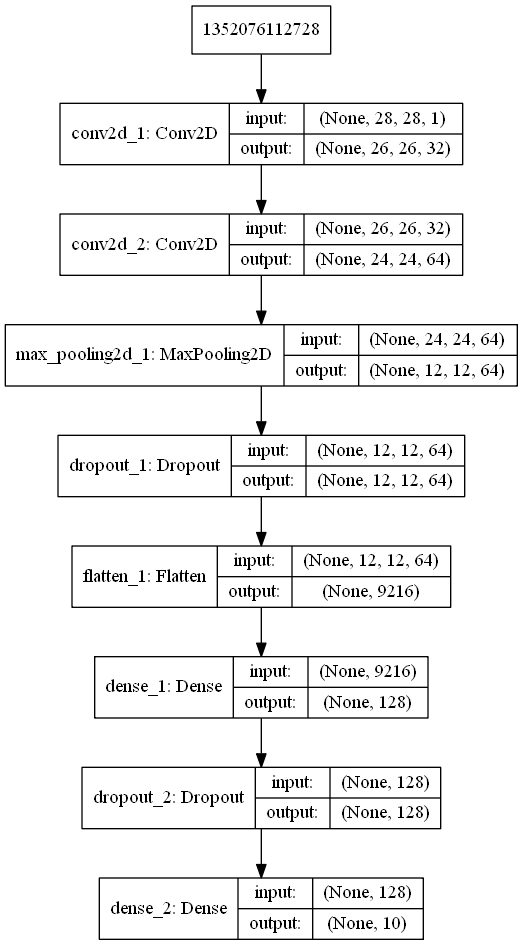

In [87]:
from IPython.display import Image
Image(filename='img/model_plot.png')

The first layer accepts the 28x28 matrix, then it is dropped down to 26x26x32 (26x26 is a side effect of pooling, and 32 indicates the filters) and once more to 24x24x64 (another dimensional reduction for pooling and 64 filters). Then it is pooled again, then dropped out, then flattened into a very long vector, then run through two densely connected layers which eventually output a vector classification. That sounds exactly like what we were hoping to do. <br/> <br/> Fitting a model exposes some statistics about it which are available for graphing. Let's look at a few characteristics of the training process to evaluate how the network did. (The below code only runs when you manually train a new network.)

In [79]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='center right')
plt.show()

NameError: name 'history' is not defined

Here we gather a list of the network's predictions and then compare it to the actual predictions.

In [39]:
predictions = model.predict_classes(X_test, batch_size=2048, verbose=1)


8400/8400 [==============================] - 10s 1ms/step


In [40]:
print(predictions)

[3 7 6 ... 0 8 7]


Store the decoded test data for later usage.

In [41]:
decodedY = np.empty(8400, dtype=int)
for i in range(y_test.shape[0]):
    decodedY[i] = int(np.argmax(y_test[i]))
print(decodedY)

[3 7 6 ... 0 8 7]


Then we create a new dataframe of all the incorrect answers.

In [42]:
wrongDf = pd.DataFrame(columns=['Guess', 'Actual'])
allDf = pd.DataFrame(columns=['Guess', 'Actual']) # might be useful
for i in range(len(predictions)):
    allDf = allDf.append({'Guess' : predictions[i], 'Actual' : decodedY[i]}, ignore_index=True)
    if (predictions[i] != decodedY[i]):
        wrongDf = wrongDf.append({'Guess' : predictions[i], 'Actual' : decodedY[i]}, ignore_index=True)

wrongDf is a dataframe of all of the predictions the network got wrong. We will see if there are any peculiar trends among the data.

In [43]:
wrongDf.head()

,Guess,Actual
0,6,0
1,7,1
2,0,4
3,8,9
4,3,8


In [44]:
wrongDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 2 columns):
Guess     138 non-null object
Actual    138 non-null object
dtypes: object(2)
memory usage: 2.2+ KB


The plot below counts up all of the mistakes the network made. These counts represent which numbers were the hardest to identify.

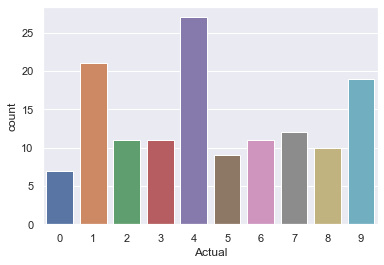

In [45]:
misclassifications = sns.countplot(x="Actual", data=wrongDf)

When the network made a mistake, these counts represent the number the network tried to guess the most.

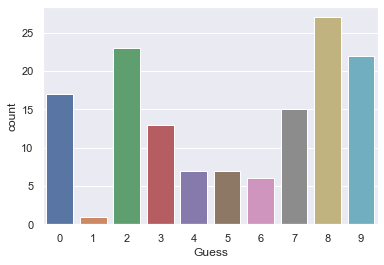

In [46]:
wrongGuesses = sns.countplot(x="Guess", data=wrongDf)

Strange. When the model guesses incorrectly, it mostly messes up when identifynig 1s, 4s, and 9s. It generally doesn't guess 1 4 5 or 6. These trends may be due to the fact that poorly drawn 9s can come to resemble 8s, and 4s can begin to look like 9s when the stem is extended. <br/><br/>Let's see which numbers are usually being confused for which. When the network identifies a 2, where is that occuring?

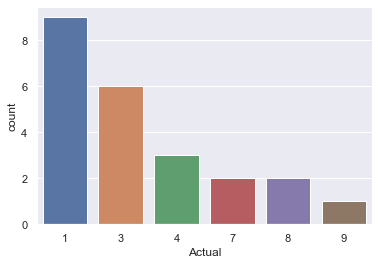

In [49]:
misclassificationsOn2Df = wrongDf[wrongDf["Guess"] == 2]
misclassificationsOn2 = sns.countplot(x="Actual", data=misclassificationsOn2Df)

Why 1 and 3? Did the network mistakenly learn some sort of relationship between "adjacent" numbers? Let's check this elsewhere.

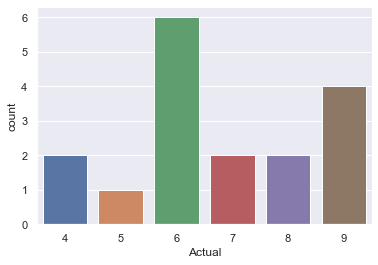

In [50]:
misclassificationsOn0Df = wrongDf[wrongDf["Guess"] == 0]
misclassificationsOn2 = sns.countplot(x="Actual", data=misclassificationsOn0Df)

The numbers with loops in them (6, 8, 9, 0) seem to be confused for each other, maybe because they can look similar? Also notable is that 0 is never mistaken for 1, which provides evidence against networks building a relationship between "adjacent" numbers. Let's go ahead and print out a copmlete confusion matrix for our network to make sure we've caught everything. 

In [51]:
from sklearn.metrics import confusion_matrix
report = confusion_matrix(y_test.argmax(axis=1), predictions) 
#predictions was already decoded, no need for argmax
print(report)

[[876   0   0   0   1   0   2   0   4   0]
 [  0 920   9   2   1   1   1   4   2   1]
 [  0   0 855   2   2   0   0   5   2   0]
 [  0   0   6 843   0   1   0   1   3   0]
 [  2   0   3   0 783   0   3   0   3  16]
 [  1   0   0   4   0 775   0   0   2   2]
 [  6   0   0   0   1   0 800   0   4   0]
 [  2   1   2   3   0   0   0 832   2   2]
 [  2   0   2   2   0   3   0   0 829   1]
 [  4   0   1   0   2   2   0   5   5 749]]


The cells below are the first steps toward improving accuracy of the network. Here we perform data augmentation, where we can rotate the image up to 10 degrees, change the scale by up to +-10%, and shift the image left right up or down up to 10%. This introduces noise into the data and begins to approach the noisier data that real life will produce.

In [122]:
augmentedModel = Sequential()
augmentedModel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
augmentedModel.add(Conv2D( 64, (3, 3), activation='relu'))
augmentedModel.add(MaxPooling2D(pool_size=(2, 2)))
augmentedModel.add(Dropout(rate = .25))
augmentedModel.add(Flatten())
augmentedModel.add(Dense(128, activation='relu'))
augmentedModel.add(Dropout(rate = .5))
augmentedModel.add(Dense(10, activation='softmax'))
augmentedModel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['acc', 'mse'])

In [57]:
augmentedModel = load_model('models/augmented model 1.h5')

W0807 09:53:46.894803  6268 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [133]:
augmentedModel.save('models/augmented model 1.h5')

In [53]:
augment = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            zoom_range = .7,
            width_shift_range=.2,
            height_shift_range=.2)

In [125]:
augment.fit(X_train)

In [126]:
augmentedHistory = augmentedModel.fit_generator(augment.flow(
          X_train, 
          y_train,
          batch_size = 128),
          epochs = 10,
          verbose=1,
          steps_per_epoch=312,
          validation_data=(X_test, y_test),
          )

Epoch 1/10
312/312 [==============================] - 52s 167ms/step - loss: 14.1748 - acc: 0.1117 - mean_squared_error: 0.1767 - val_loss: 13.0457 - val_acc: 0.1895 - val_mean_squared_error: 0.1617
Epoch 2/10
312/312 [==============================] - 51s 165ms/step - loss: 13.7751 - acc: 0.1411 - mean_squared_error: 0.1714 - val_loss: 12.4378 - val_acc: 0.2246 - val_mean_squared_error: 0.1548
Epoch 3/10
312/312 [==============================] - 51s 164ms/step - loss: 13.7428 - acc: 0.1440 - mean_squared_error: 0.1708 - val_loss: 12.0591 - val_acc: 0.2498 - val_mean_squared_error: 0.1498
Epoch 4/10
312/312 [==============================] - 52s 166ms/step - loss: 13.5568 - acc: 0.1559 - mean_squared_error: 0.1685 - val_loss: 11.5346 - val_acc: 0.2837 - val_mean_squared_error: 0.1431
Epoch 5/10
312/312 [==============================] - 51s 165ms/step - loss: 13.3967 - acc: 0.1663 - mean_squared_error: 0.1665 - val_loss: 10.4954 - val_acc: 0.3452 - val_mean_squared_error: 0.1306
Epoch

Woof. That's a little rough. Maybe our augmentation isn't tuned right. Let's check the errors before we go any further. We'll gather our errors and their actual values, and see where the network is making mistakes.

In [58]:
predictions = augmentedModel.predict_classes(X_test, batch_size=2048, verbose=1)

augmentedWrongDf = pd.DataFrame(columns=['Guess', 'Actual'])
for i in range(len(predictions)):
    if (predictions[i] != decodedY[i]):
        augmentedWrongDf = augmentedWrongDf.append({'Guess' : predictions[i], 'Actual' : decodedY[i]}, ignore_index=True)

8400/8400 [==============================] - 10s 1ms/step


In [60]:
augmentedWrongDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4621 entries, 0 to 4620
Data columns (total 2 columns):
Guess     4621 non-null object
Actual    4621 non-null object
dtypes: object(2)
memory usage: 72.3+ KB


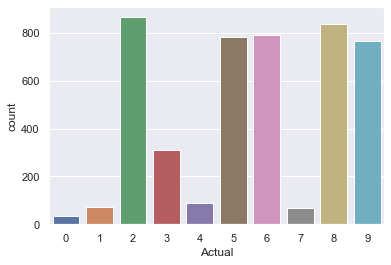

In [59]:
augmentedInaccuracyDf = sns.countplot(x="Actual", data=augmentedWrongDf)

While the accuracy is terrible, this actually makes sense. If you rotate 5 and 2, they will look similar enough that a network can probably make mistakes distinguishing them. The same goes for 6 and 9, and 8 has always been a problem. Let's cut back on the strength of the augmentation and try again. The next few cells are together for convenience.

In [61]:
augmentedModel = load_model('model/augmented model 2.h5')

W0807 09:58:57.021447  6268 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [134]:
augmentedModel = Sequential()
augmentedModel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
augmentedModel.add(Conv2D( 64, (3, 3), activation='relu'))
augmentedModel.add(MaxPooling2D(pool_size=(2, 2)))
augmentedModel.add(Dropout(rate = .25))
augmentedModel.add(Flatten())
augmentedModel.add(Dense(128, activation='relu'))
augmentedModel.add(Dropout(rate = .5))
augmentedModel.add(Dense(10, activation='softmax'))
augmentedModel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['acc', 'mse'])
augment = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=5,
            zoom_range = .1,
            width_shift_range=.1,
            height_shift_range=.1)
augment.fit(X_train)
augmentedHistory = augmentedModel.fit_generator(augment.flow(
          X_train, 
          y_train,
          batch_size = 128),
          epochs = 10,
          verbose=1,
          steps_per_epoch=312,
          validation_data=(X_test, y_test),
          )

Epoch 1/10
312/312 [==============================] - 52s 167ms/step - loss: 9.3233 - acc: 0.3273 - mean_squared_error: 0.1270 - val_loss: 0.7123 - val_acc: 0.8383 - val_mean_squared_error: 0.0313
Epoch 2/10
312/312 [==============================] - 51s 165ms/step - loss: 0.8289 - acc: 0.7357 - mean_squared_error: 0.0365 - val_loss: 0.1242 - val_acc: 0.9624 - val_mean_squared_error: 0.0057
Epoch 3/10
312/312 [==============================] - 52s 165ms/step - loss: 0.4171 - acc: 0.8723 - mean_squared_error: 0.0189 - val_loss: 0.0751 - val_acc: 0.9789 - val_mean_squared_error: 0.0033
Epoch 4/10
312/312 [==============================] - 52s 166ms/step - loss: 0.3106 - acc: 0.9058 - mean_squared_error: 0.0141 - val_loss: 0.0595 - val_acc: 0.9823 - val_mean_squared_error: 0.0027
Epoch 5/10
312/312 [==============================] - 51s 165ms/step - loss: 0.2631 - acc: 0.9212 - mean_squared_error: 0.0119 - val_loss: 0.0585 - val_acc: 0.9831 - val_mean_squared_error: 0.0026
Epoch 6/10
312/

In [135]:
augmentedModel.save('augmented model 2.h5')

Impressive! A little more accuracy than without augmentation. The lower training accuracy at the start but high validation accuracy suggests that we are probably putting a little too much stress on our input data, but the network will be better equipped to deal with terrible handwriting without sacrificing too much experience with cleaner data. The augmentation was only applied to the training data, which means the network was never validated with noisy data, though. We will do that manually closer to the end of the project when we insert our own images. <br/><br/><br/>Let's see where the errors are now. Let's check our classification report below.

In [68]:
augmentedPredictions = augmentedModel.predict_classes(X_test, batch_size=2048, verbose=1)

augmentedClassificationReport = classification_report(y_test.argmax(axis=1), augmentedPredictions) 
#predictions was already decoded, no need for argmax
print(augmentedClassificationReport)

8400/8400 [==============================] - 10s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       883
           1       1.00      0.98      0.99       941
           2       0.98      0.99      0.99       866
           3       0.99      0.99      0.99       854
           4       0.98      0.99      0.98       810
           5       1.00      0.99      0.99       784
           6       0.99      0.99      0.99       811
           7       0.97      1.00      0.98       844
           8       0.98      0.99      0.99       839
           9       0.98      0.96      0.97       768

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



Let's go ahead and check our our confusion matrix for the new and improved model.

In [67]:
augmentedConfusionMatrix = confusion_matrix(y_test.argmax(axis=1), augmentedPredictions) 
print(augmentedConfusionMatrix)

[[873   0   1   1   1   0   2   0   4   1]
 [  0 919  10   1   3   0   0   7   1   0]
 [  0   0 860   0   0   0   0   6   0   0]
 [  0   0   3 848   0   0   0   1   2   0]
 [  0   0   1   0 802   0   1   0   0   6]
 [  0   0   0   3   0 778   0   0   1   2]
 [  2   1   0   0   0   0 804   0   4   0]
 [  0   0   2   0   0   0   0 841   0   1]
 [  0   1   1   1   2   1   2   1 828   2]
 [  3   0   0   2  11   1   0   8   2 741]]


Good numbers! It also appears we've managed to eliminate 4 as a source of error!

Now that we have some rudimentary training done, lets try the data out on the real deal: My own terrible handwriting! <br/> <br/> First, we will take the images and prepare them.

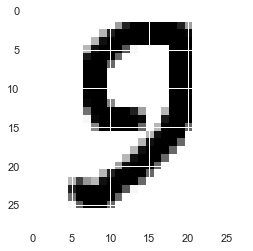

In [69]:
import matplotlib.image as mpimg
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989,0.5870,0.1140]) #color -> grayscale conversion values

img = mpimg.imread('ourdata/test.png')     
gray = rgb2gray(img) #just in case.
plt.imshow(gray, cmap=plt.get_cmap('gray_r'), vmin=0, vmax=1)
plt.show()


Then we'll manually reshape our data into a form the network will accept. Nothing really changes, it just has a few empty portions. Then we run a prediction on our lone number, then check it. We also check the pixel data to ensure it looks like the other data. 0 for white, 255 for black. To easily create new data, draw white letters on a black canvas in MSPaint.

In [47]:
newnum = np.empty(shape=(1, 28, 28, 1))
for i in range(len(newnum[0])):
    for j in range(len(newnum[0][0])):
        newnum[0][i][j][0] = (gray[i][j]) * 255 # to match the MNIST data properly
predicts = augmentedModel.predict_classes(newnum)
print(predicts[0])

9


That number above is the network's guess. For this image, it was spot on. We also tested it on several other instances as well as community suggestions from MOSTEC students.

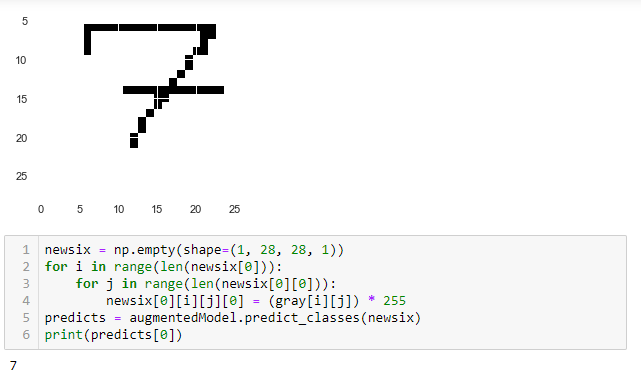

In [82]:
from IPython.display import Image
Image(filename='img/test7.png')

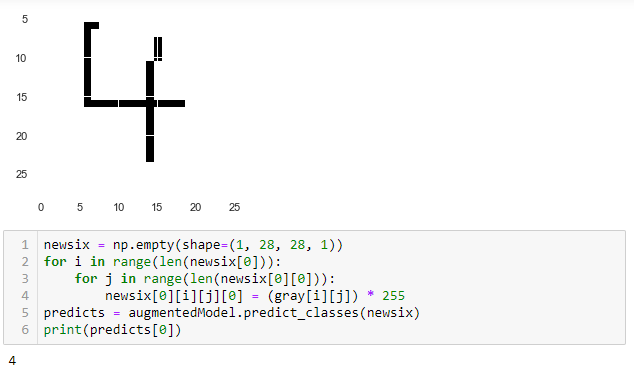

In [83]:
from IPython.display import Image
Image(filename='img/test4.png')

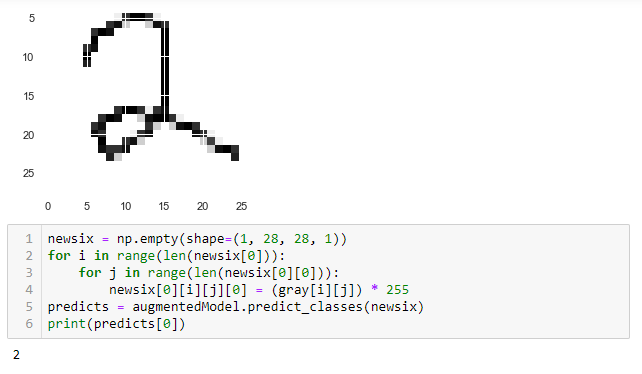

In [84]:
from IPython.display import Image
Image(filename='img/test2.png')

<h1>Thank You!</h1>